In [2]:
# Check the input directories
import os
print(os.listdir('../../retinopathy-dataset-master'))
# print(os.listdir('../../retinopathy-dataset-master/symptoms'))

['nosymptoms', 'README.md', 'retinopathy_solution.csv', 'symptoms']


In [3]:
# Read image names
import pandas as pd
df = pd.read_csv(r"../../retinopathy-dataset-master/symptoms/newTrainLabels.csv")
df.head()

,image,level,MB
0,10_left,0,0.146893
1,10_right,0,0.134647
2,13_left,0,0.179653
3,13_right,0,0.173361
4,15_left,1,0.129906


In [4]:
# Create image data generator
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split = 0.25)

oo = """ All possible features for ImageDataGenerator and their default values
For more details, see: https://keras.io/preprocessing/image/

datagen = ImageDataGenerator(
    featurewise_center = False, 
    samplewise_center = False, 
    featurewise_std_normalization = False, 
    samplewise_std_normalization = False, 
    zca_whitening = False, 
    zca_epsilon = 1e-06, 
    rotation_range = 0, 
    width_shift_range = 0.0, 
    height_shift_range = 0.0, 
    brightness_range = None, 
    shear_range = 0.0, 
    zoom_range = 0.0, 
    channel_shift_range = 0.0, 
    fill_mode = 'nearest', 
    cval = 0.0, 
    horizontal_flip = False, 
    vertical_flip = False, 
    rescale = None, 
    preprocessing_function = None, 
    data_format = None,
    validation_split = 0.0,
    dtype = None)
"""

# Create data generators
train_generator = datagen.flow_from_dataframe(
    dataframe = df, 
    directory = "../../retinopathy-dataset-master/symptoms",
    has_ext = False,
    x_col = "image", 
    y_col = "level", 
    class_mode = "categorical", 
    target_size = (100, 100), 
    batch_size = 16,
    subset = 'training')

valid_generator = datagen.flow_from_dataframe(
    dataframe = df, 
    directory = "../../retinopathy-dataset-master/symptoms",
    has_ext = False,
    x_col = "image", 
    y_col = "level", 
    class_mode = "categorical", 
    target_size = (100, 100), 
    batch_size = 16,
    subset = 'validation')

oo = """ All possible settings for flow_from_dataframe
generator = flow_from_dataframe(
    dataframe, 
    directory = None, 
    x_col = 'filename', 
    y_col = 'class', 
    target_size = (256, 256), 
    color_mode = 'rgb', 
    classes = None, 
    class_mode = 'categorical', 
    batch_size = 32, 
    shuffle = True, 
    seed = None, 
    save_to_dir = None, 
    save_prefix = '', 
    save_format = 'png', 
    subset = None, 
    interpolation = 'nearest', 
    drop_duplicates = True)
"""

Using TensorFlow backend.


Found 447 images belonging to 5 classes.
Found 148 images belonging to 5 classes.


In [5]:
# Create a basic Sequential model with several Conv2D layers

from keras import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from keras import optimizers

model = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (100, 100, 3)))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation = 'softmax'))

# Try a custom metrics, needs to be calculated in backend (Tensorflow)  
from keras import backend
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer = sgd,
             loss='categorical_crossentropy', 
              metrics = ["accuracy", "mse", rmse])

oo = """ All possible options for model.compile
For more details, see: https://keras.io/models/model/
model.compile( 
    optimizer, 
    loss = None, 
    metrics = None, 
    loss_weights = None, 
    sample_weight_mode = None, 
    weighted_metrics = None,
    target_tensors = None)
"""

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
__________

In [6]:
# Calculate how many batches are needed to go through whole train and validation set
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
N = 10 # Number of epochs

# Train and count seconds
from time import time
t1 = time()
h = model.fit_generator(generator = train_generator,
                    steps_per_epoch = 50, #STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = 15, #STEP_SIZE_VALID,
                    epochs = N,
                    verbose = 2)
t2 = time()
elapsed_time = (t2 - t1)

oo = """All settings for model.fit_generator
model.fit_generator(
    generator, 
    steps_per_epoch=None, 
    epochs=1, 
    verbose=1, 
    callbacks=None, 
    validation_data=None, 
    validation_steps=None, 
    validation_freq=1, 
    class_weight=None, 
    max_queue_size=10, 
    workers=1, 
    use_multiprocessing=False, 
    shuffle=True, 
    initial_epoch=0)
"""

# Save the model
model.save('case2.h5')

# Print the total elapsed time and average time per epoch in format (hh:mm:ss)
from time import localtime, strftime
t_total = strftime('%H:%M:%S', localtime(t2 - t1))
t_per_e = strftime('%H:%M:%S', localtime((t2 - t1)/N))
print('Total elapsed time for {:d} epochs: {:s}'.format(N, t_total))
print('Average time per epoch:             {:s}'.format(t_per_e))

Epoch 1/10
 - 64s - loss: 1.1886 - acc: 0.4983 - mean_squared_error: 0.1285 - rmse: 0.3440 - val_loss: 1.0896 - val_acc: 0.5877 - val_mean_squared_error: 0.1214 - val_rmse: 0.3431
Epoch 2/10
 - 58s - loss: 1.1498 - acc: 0.5374 - mean_squared_error: 0.1242 - rmse: 0.3364 - val_loss: 1.1844 - val_acc: 0.5463 - val_mean_squared_error: 0.1258 - val_rmse: 0.3495
Epoch 3/10
 - 59s - loss: 1.1208 - acc: 0.5278 - mean_squared_error: 0.1237 - rmse: 0.3374 - val_loss: 1.0673 - val_acc: 0.5746 - val_mean_squared_error: 0.1167 - val_rmse: 0.3241
Epoch 4/10
 - 59s - loss: 1.1249 - acc: 0.5512 - mean_squared_error: 0.1232 - rmse: 0.3365 - val_loss: 1.0848 - val_acc: 0.5602 - val_mean_squared_error: 0.1192 - val_rmse: 0.3351
Epoch 5/10
 - 60s - loss: 1.1268 - acc: 0.5353 - mean_squared_error: 0.1231 - rmse: 0.3380 - val_loss: 1.0685 - val_acc: 0.5658 - val_mean_squared_error: 0.1181 - val_rmse: 0.3223
Epoch 6/10
 - 59s - loss: 1.1197 - acc: 0.5336 - mean_squared_error: 0.1235 - rmse: 0.3380 - val_los

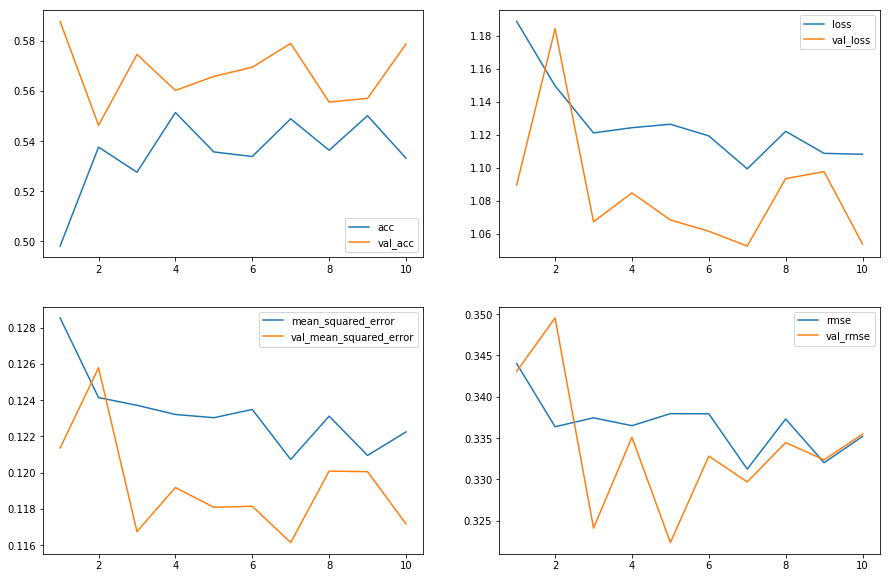

In [7]:
# Variable names available in h.history
# loss, val_loss
# acc, val_acc
# mean_squared_error, val_mean_squared_erro
# rmse, val_rmse

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(N) + 1.0

f, ax = plt.subplots(2, 2, figsize = (15,10))

def plotter(ax, epochs, h, variable):
    ax.plot(epochs, h.history[variable], label = variable)
    ax.plot(epochs, h.history['val_' + variable], label = 'val_'+variable)
    ax.legend()

plotter(ax[0][0], epochs, h, 'acc')
plotter(ax[0][1], epochs, h, 'loss')
plotter(ax[1][0], epochs, h, 'mean_squared_error')
plotter(ax[1][1], epochs, h, 'rmse')
plt.show()